In [1]:
import numpy as np
import tensorflow as tf
import matplotlib.pyplot as plt
from Nclasses import labels
import inspect
import os
import time
from skimage import io, transform
from pylab import mpl
%matplotlib inline
mpl.rcParams['font.sans-serif']=['SimHei'] # 正常显示中文标签
mpl.rcParams['axes.unicode_minus']=False # 正常显示正负号

In [2]:
VGG_MEAN = [103.939, 116.779, 123.68] 

In [3]:
class Vgg16():
    def __init__(self,vgg16_path=None):
        if(vgg16_path is None):
            vgg16_path = os.path.join(os.getcwd(), "vgg16.npy") 
            self.data_dict = np.load(vgg16_path, encoding='latin1').item() 
    def forward(self, images):
        print("build model started")
        start_time = time.time() 
        rgb_scaled = images * 255.0
        red, green, blue = tf.split(rgb_scaled,3,3)
        assert red.get_shape().as_list()[1:] == [224, 224, 1]
        assert green.get_shape().as_list()[1:] == [224, 224, 1]
        assert blue.get_shape ().as_list()[1:] == [224, 224, 1]
        bgr = tf.concat([     
            blue - VGG_MEAN[0],
            green - VGG_MEAN[1],
            red - VGG_MEAN[2]],3)
        assert bgr.get_shape().as_list()[1:] == [224, 224, 3]
        self.conv1_1 = self.conv_layer(bgr, "conv1_1") 
        self.conv1_2 = self.conv_layer(self.conv1_1, "conv1_2")
        self.pool1 = self.max_pool_2x2(self.conv1_2, "pool1")
        
        self.conv2_1 = self.conv_layer(self.pool1, "conv2_1")
        self.conv2_2 = self.conv_layer(self.conv2_1, "conv2_2")
        self.pool2 = self.max_pool_2x2(self.conv2_2, "pool2")

        self.conv3_1 = self.conv_layer(self.pool2, "conv3_1")
        self.conv3_2 = self.conv_layer(self.conv3_1, "conv3_2")
        self.conv3_3 = self.conv_layer(self.conv3_2, "conv3_3")
        self.pool3 = self.max_pool_2x2(self.conv3_3, "pool3")
        
        self.conv4_1 = self.conv_layer(self.pool3, "conv4_1")
        self.conv4_2 = self.conv_layer(self.conv4_1, "conv4_2")
        self.conv4_3 = self.conv_layer(self.conv4_2, "conv4_3")
        self.pool4 = self.max_pool_2x2(self.conv4_3, "pool4")
        
        self.conv5_1 = self.conv_layer(self.pool4, "conv5_1")
        self.conv5_2 = self.conv_layer(self.conv5_1, "conv5_2")
        self.conv5_3 = self.conv_layer(self.conv5_2, "conv5_3")
        self.pool5 = self.max_pool_2x2(self.conv5_3, "pool5")
        
        self.fc6 = self.fc_layer(self.pool5, "fc6") 
        self.relu6 = tf.nn.relu(self.fc6) 
        
        self.fc7 = self.fc_layer(self.relu6, "fc7")
        self.relu7 = tf.nn.relu(self.fc7)
        
        self.fc8 = self.fc_layer(self.relu7, "fc8")
        self.prob = tf.nn.softmax(self.fc8, name="prob")
        
        end_time = time.time() 
        print(("time consuming: %f" % (end_time-start_time)))

        self.data_dict = None 
    def conv_layer(self, x, name):
        with tf.variable_scope(name):
            w = self.get_conv_filter(name)
            b = self.get_bias(name)
            conv = tf.nn.conv2d(x,w,strides = [1,1,1,1],padding = "SAME")
            result = tf.nn.relu(tf.nn.bias_add(conv, b)) 
            return result
    def get_conv_filter(self, name):
        w = tf.constant(self.data_dict[name][0], name="filter") 
        return w
    def get_bias(self, name):
        b = tf.constant(self.data_dict[name][1], name="biases") 
        return b
    def max_pool_2x2(self, x, name):
        pool = tf.nn.max_pool(x, ksize=[1, 2, 2, 1], strides=[1, 2, 2, 1], padding='SAME', name=name)
        return pool
    def fc_layer(self, x, name):
        with tf.variable_scope(name): 
            shape = x.get_shape().as_list() 
            dim = 1
            for i in shape[1:]:
                dim *= i 
            x = tf.reshape(x, [-1, dim])
            w = self.get_fc_weight(name) 
            b = self.get_bias(name) 

            result = tf.nn.bias_add(tf.matmul(x, w), b) 
            return result
    
    def get_fc_weight(self, name):  
        fc = tf.constant(self.data_dict[name][0], name="weights")
        return fc

In [4]:
def load_image(path):
    fig = plt.figure("Centre and Resize")
    img = io.imread(path)
    img = img / 255.0
    
    ax0 = fig.add_subplot(131)  
    ax0.set_xlabel(u'Original Picture') 
    ax0.imshow(img) 
    
    short_edge = min(img.shape[:2]) 
    y = (img.shape[0] - short_edge) // 2  
    x = (img.shape[1] - short_edge) // 2 
    crop_img = img[y:y+short_edge, x:x+short_edge] 
    ax1 = fig.add_subplot(132) 
    ax1.set_xlabel(u"Centre Picture") 
    ax1.imshow(crop_img)
    
    re_img = transform.resize(crop_img, (224, 224)) 
    
    ax2 = fig.add_subplot(133) 
    ax2.set_xlabel(u"Resize Picture") 
    ax2.imshow(re_img)

    img_ready = re_img.reshape((1, 224, 224, 3))

    return img_ready

In [5]:
def percent(value):
    return '%.2f%%' % (value * 100)

In [6]:
def predict():
    img_path = input('Input the path and image name:')
    img_ready = load_image(img_path)
    fig=plt.figure(u"Top-5 预测结果") 
    with tf.Session() as sess:
        images = tf.placeholder(tf.float32,[1,224,224,3])
        vgg = Vgg16()
        vgg.forward(images)
        probability = sess.run(vgg.prob, feed_dict={images:img_ready})
        top5 = np.argsort(probability[0])[-1:-6:-1]
        print ("top5:",top5)
        values = []
        bar_label = []
        for n, i in enumerate(top5): 
            print("n:",n)
            print ("i:",i)
            values.append(probability[0][i]) 
            bar_label.append(labels[i]) 
            print(i, ":", labels[i], "----", percent(probability[0][i])) 
        ax = fig.add_subplot(111) 
        ax.bar(range(len(values)), values, tick_label=bar_label, width=0.5, fc='g')
        ax.set_ylabel(u'probabilityit') 
        ax.set_title(u'Top-5') 
        for a,b in zip(range(len(values)), values):
            ax.text(a, b+0.0005, percent(b), ha='center', va = 'bottom', fontsize=7)   
        plt.show() 

这里，tf.placeholder的用法不同于以往，之前是tf.placeholder与tf.variable传递函数

Input the path and image name:pic/1.jpg


C:\Users\Administrator\AppData\Roaming\Python\Python36\site-packages\skimage\transform\_warps.py:105: UserWarning: The default mode, 'constant', will be changed to 'reflect' in skimage 0.15.
  warn("The default mode, 'constant', will be changed to 'reflect' in "
C:\Users\Administrator\AppData\Roaming\Python\Python36\site-packages\skimage\transform\_warps.py:110: UserWarning: Anti-aliasing will be enabled by default in skimage 0.15 to avoid aliasing artifacts when down-sampling images.
  warn("Anti-aliasing will be enabled by default in skimage 0.15 to "


build model started
time consuming: 4.523216
top5: [336 337 335 360 299]
n: 0
i: 336
336 : marmot ---- 99.94%
n: 1
i: 337
337 : beaver ---- 0.06%
n: 2
i: 335
335 : fox squirrel
 eastern fox squirrel
 Sciurus niger ---- 0.00%
n: 3
i: 360
360 : otter ---- 0.00%
n: 4
i: 299
299 : meerkat
 mierkat ---- 0.00%


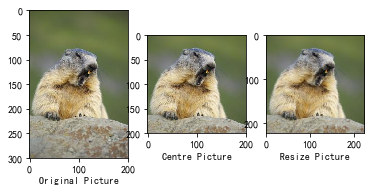

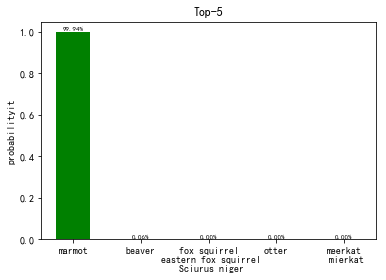

In [7]:
predict()